In [1]:
import cv2
import numpy as np
from skimage.morphology import disk, erosion
import matplotlib.pyplot as plt

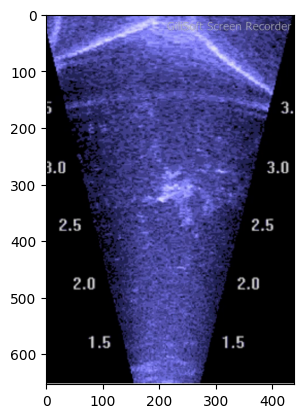

In [2]:
image = cv2.imread( "sample.png")	# reading input image

image = cv2.cvtColor( image, cv2.COLOR_BGR2RGB)	# converting color channels from BGR to RGB

plt.imshow( image)

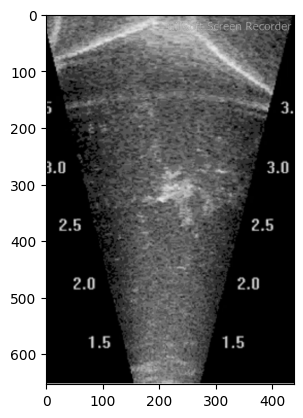

In [3]:
gray_image = cv2.cvtColor( image, cv2.COLOR_BGR2GRAY)	# converting image to Gray

plt.imshow( gray_image, cmap="gray")

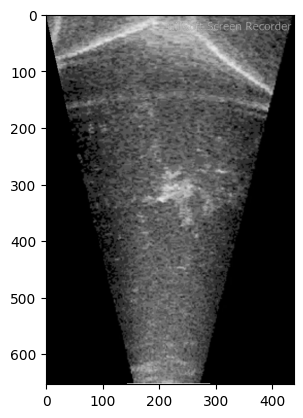

In [4]:
# removing unwanted margins

height, width = gray_image.shape

mask = np.zeros_like( gray_image)

# creating a polygon shape for interested region/area
polygon = np.array( [
	[ width * 0.33, height],	# Bottom-left
	[ width * 0.66, height],	# Botton-Right
	[ width, 0],				# Top-Right
	[ 0, 0],					# Top-Left
], np.int32)

mask = cv2.fillPoly( mask, [ polygon], 255)

masked_image = cv2.bitwise_and( gray_image, mask)

plt.imshow( masked_image, cmap="gray")

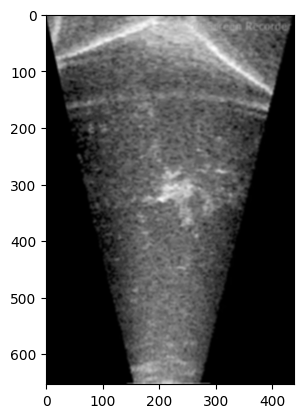

In [5]:
# Bluring Image for denoising
blurred_image = cv2.GaussianBlur( masked_image, ( 5, 5), sigmaX=2, sigmaY=2)

plt.imshow( blurred_image, cmap="gray")

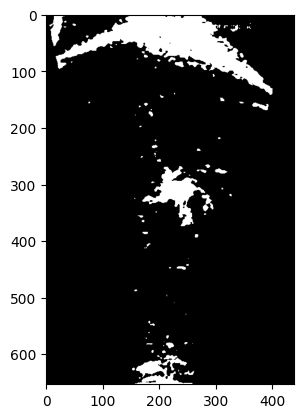

In [6]:
# Thresholding the brightness

c = 0.5

_, binary_image = cv2.threshold( blurred_image, c * 255, 255, cv2.THRESH_BINARY)

plt.imshow( binary_image, cmap="gray")

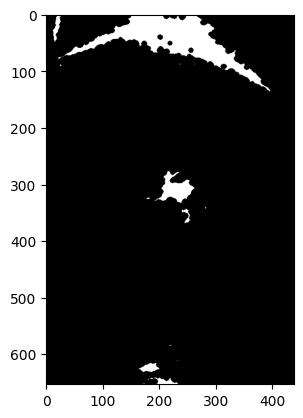

In [7]:
# Eroding the binary image to remove small noise

footprint = disk( 4)

eroded_frame = erosion( binary_image, footprint)

plt.imshow( eroded_frame, cmap="gray")

In [8]:
# selecting bright pixels
bright_pixels = np.column_stack( np.where( binary_image > 0))

In [96]:
# KMeans Clustering Algorithm with Minimum Centeroid Distance Constraint

def co_dist( centeroids):
	c = np.array( [ [ np.linalg.norm( centeroids[ i] - centeroids[ j]) for j in range( len( centeroids))] for i in range( len( centeroids))])

	for i in range( len( c)):
		c[ i][ i] = float( "inf")

	return c

def Kmeans( X, k, min_dist, tol=1e-4, max_iter=100, n_iter=10):
	
	# n: number of samples
	# f: number of features
	n, f = X.shape

	best_inertia = float( "inf")
	best_centeroids = None
	best_lables = None

	for _ in range( n_iter):
		
		np.random.seed()
		centeroids = X[ np.random.choice( n, k, replace=False)].astype( float)

		for _ in range( max_iter):
			new_centeroids = centeroids.copy()

			distances = np.linalg.norm( X[ :, np.newaxis] - centeroids, axis=2)
			
			labels = np.argmin( distances, axis=1)

			for i in range( k):
				if len( X[ labels == i]) > 0:
					step = np.mean( X[ labels == i], axis=0) - centeroids[ i]
				else:
					step = np.zeros_like( centeroids[ i])
					
				new_centeroids[ i] += step

			if np.linalg.norm( new_centeroids - centeroids) < tol:
				break

			centeroids = new_centeroids

		c = co_dist( centeroids)

		while ( c < min_dist).any():
			a, b = np.unravel_index( c.argmin(), c.shape)
			
			centeroids[ a] = ( centeroids[ a] + centeroids[ b]) / 2

			centeroids = np.delete( centeroids, b, axis=0)

			c = co_dist( centeroids)

		distances = np.linalg.norm( X[ :, np.newaxis] - centeroids, axis=2)
		inertia = np.sum( np.min( distances, axis=1) ** 2)

		if inertia < best_inertia:
			best_inertia = inertia
			best_centeroids = centeroids
			best_lables = labels

	return best_centeroids, best_lables


In [103]:
# Perform K-Means clustering on the bright pixels
clusters, lables = Kmeans( X=bright_pixels,
						   k=10,
						   min_dist=200,
						   tol=1e-4,
						   max_iter=50,
						   n_iter=5)

In [104]:
clusters

array([[ 38.37768794, 120.27425452],
       [ 88.98698051, 319.99690754],
       [625.42150039, 202.21268368],
       [317.42339132, 234.35883463]])

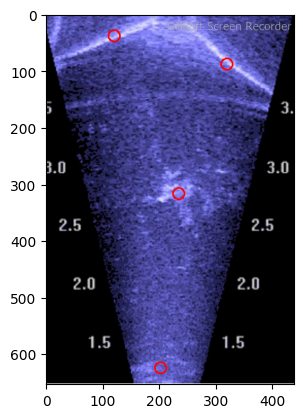

In [105]:
cluster_centers = clusters.astype( int)
output_image = image.copy()

for c in cluster_centers:
	cv2.circle( output_image, ( c[ 1], c[ 0]), 10, ( 255, 0, 0), 2)

plt.imshow( output_image)

In [102]:
np.array( cluster_centers)

array([[327, 238],
       [ 31, 158],
       [ 48,  50],
       [602, 204],
       [ 48, 261],
       [111, 355]])

In [106]:
def read_every_nth_frame( video_capture, n):
	frame_count = 0
	frames = []
	while video_capture.isOpened():
		ret, frame = video_capture.read()

		if not ret:
			break

		if frame_count % n == 0:
			frames.append( cv2.cvtColor( frame, cv2.COLOR_BGR2RGB))

		frame_count += 1

	return np.array( frames)

In [107]:
cap = cv2.VideoCapture( "image/MyRecord_20241116133821.mp4")

if cap.isOpened() == False:
	print( "Error Opening Video stream")

frames = read_every_nth_frame( cap, 1)

In [110]:
from tqdm.auto import tqdm

def generate( frames):
	output = []

	for f in tqdm( frames):
		output_image = f.copy()

		gray_frame = cv2.cvtColor( f, cv2.COLOR_BGR2GRAY)

		height, width = gray_frame.shape

		mask = np.zeros_like( gray_frame)

		polygon = np.array( [
			[ width * 0.33, height],	# Bottom-left
			[ width * 0.66, height],	# Botton-Right
			[ width, 0],				# Top-Right
			[ 0, 0],					# Top-Left
		], np.int32)

		mask = cv2.fillPoly( mask, [ polygon], 255)

		masked_image = cv2.bitwise_and( gray_frame, mask)

		blurred_frame = cv2.GaussianBlur( masked_image, ( 5, 5), sigmaX=2, sigmaY=2)

		c = 0.5

		_, binary_frame = cv2.threshold( blurred_frame, c * 255, 255, cv2.THRESH_BINARY)

		footprint = disk( 4)

		eroded_frame = erosion( binary_frame, footprint)

		bright_pixels = np.column_stack( np.where( eroded_frame > 0))

		k = 10
		min_dist = 200
		tol = 1e-4
		max_iter = 25
		n_iter = 3
		
		if len( bright_pixels) < 1:
			output.append( output_image)
			continue

		clusters, lables = Kmeans( X=bright_pixels,
								   k=k,
								   min_dist=min_dist,
								   tol=tol,
								   max_iter=max_iter,
								   n_iter=n_iter)

		cluster_centers = clusters.astype( int)

		for c in cluster_centers:
			cv2.circle( output_image, ( c[ 1], c[ 0]), 10, ( 255, 0, 0), 2)

		output.append( output_image)

	return output

In [111]:
o = generate( frames)

  0%|          | 0/597 [00:00<?, ?it/s]

In [112]:
height, width, _ = o[ 0].shape

fourcc = cv2.VideoWriter_fourcc( *"MP4V")
video = cv2.VideoWriter( "videogg.mp4", fourcc, 24, ( width, height))

for f in o:
	video.write( cv2.cvtColor( f, cv2.COLOR_RGB2BGR))

video.release()